In [1]:
import os
import sys
import xesmf as xe
import scipy as sp
import numpy as np
import xarray as xr
import cmocean
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
matplotlib.rc_file('rc_file_paper')
%load_ext autoreload
%autoreload 2
%aimport - numpy - scipy - matplotlib.pyplot

In [3]:
from maps import add_cyclic_POP, add_cyclic_rectangular
from grid import generate_lats_lons
from paths import path_results, path_prace, file_ex_ocn_ctrl, file_ex_ocn_lpd, file_RMASK_ocn, file_RMASK_ocn_low
from FW_plots import lat_bounds, lons_lats_from_sdict
from FW_budget import load_obj
from obs_cesm_maps import bias_maps
from xr_regression import ocn_field_regression, xr_regression_with_stats

In [4]:
dsh = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False)
dsl = xr.open_dataset(file_ex_ocn_lpd, decode_times=False)
RMASK_ocn = xr.open_dataarray(file_RMASK_ocn)
RMASK_low = xr.open_dataarray(file_RMASK_ocn_low)
Atl_MASK_ocn = xr.DataArray(np.in1d(RMASK_ocn, [6,8,9]).reshape(RMASK_ocn.shape),
                            dims=RMASK_ocn.dims, coords=RMASK_ocn.coords)
Atl_MASK_low = xr.DataArray(np.in1d(RMASK_low, [6,8,9]).reshape(RMASK_low.shape),
                            dims=RMASK_low.dims, coords=RMASK_low.coords)

In [5]:
# SST(x,y) time mean
SST_ctrl = xr.open_dataset(f'{path_prace}/SST/SST_yrly_ctrl.nc', decode_times=False).SST.isel(time=slice(200,230)).mean('time')
SST_lpd  = xr.open_dataarray(f'{path_prace}/SST/SST_yrly_lpd.nc' , decode_times=False).isel(time=slice(500-154,530-154)).mean('time')
SST_had  = xr.open_dataarray(f'{path_prace}/SST/SST_yrly_had.nc' , decode_times=False).isel(time=slice(-30,-1)).mean('time')

In [6]:
# fixing geometry
lat_lon_high = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False)[['TLAT', 'TLONG']].drop(['ULAT', 'ULONG'])
lat_lon_low  = xr.open_dataset(file_ex_ocn_lpd , decode_times=False)[['TLAT', 'TLONG']].drop(['ULAT', 'ULONG'])
SST_ctrl = xr.merge([SST_ctrl, lat_lon_high]).to_array()
SST_lpd  = xr.merge([SST_lpd , lat_lon_low ]).to_array()

In [7]:
# regridding
SST_had_ = SST_had.rename({'latitude':'lat', 'longitude':'lon'})

# regrid P-E to ECMWF grid
SST_ocn = SST_ctrl.rename({'TLAT': 'lat', 'TLONG': 'lon'})
SST_low = SST_lpd.rename({'TLAT': 'lat', 'TLONG': 'lon'})

# replace NaNs in continents with values from original grid file
lats,lons = generate_lats_lons('ocn')
SST_ocn['lat'].values = lats
SST_ocn['lon'].values = lons

regridder_ocn = xe.Regridder(SST_ocn, SST_had_, 'nearest_s2d', reuse_weights=True, periodic=True)
regridder_low = xe.Regridder(SST_low, SST_had_, 'nearest_s2d', reuse_weights=True, periodic=True)

Reuse existing file: nearest_s2d_2400x3600_180x360_peri.nc
Reuse existing file: nearest_s2d_384x320_180x360_peri.nc


In [8]:
# # calculate RCP trends, some 40 seconds
# SST_rcp  = 365*100*ocn_field_regression(xr.open_dataarray(f'{path_prace}/SST/SST_yrly_rcp.nc' , decode_times=False), run='rcp')[0]
# SST_lr1  = 365*100*ocn_field_regression(xr.open_dataset(f'{path_prace}/SST/SST_yrly_lr1.nc' , decode_times=False).SST, run='lr1')[0]

In [9]:
%%time
# calculate RCP trends
# 52 min for rcp, 40 sec for lr1
stats_rcp = xr_regression_with_stats(xr.open_dataarray(f'{path_prace}/SST/SST_yrly_rcp.nc', decode_times=False), fn=f'{path_prace}/SST/SST_yrly_rcp_stats.nc')
stats_lr1 = xr_regression_with_stats(xr.open_dataset(f'{path_prace}/SST/SST_yrly_lr1.nc', decode_times=False).SST, fn=f'{path_prace}/SST/SST_yrly_lr1_stats.nc')
stats_lr1 = stats_lr1.assign_coords({'TLAT':SST_lpd.TLAT,'TLONG':SST_lpd.TLONG})

file exists and is loaded:
  /projects/0/prace_imau/prace_2013081679/andre/SST/SST_yrly_rcp_stats.nc
file exists and is loaded:
  /projects/0/prace_imau/prace_2013081679/andre/SST/SST_yrly_lr1_stats.nc
CPU times: user 28.7 ms, sys: 17.7 ms, total: 46.4 ms
Wall time: 419 ms


In [10]:
SST_rcp = 365*100*stats_rcp.slope
SST_lr1 = 365*100*stats_lr1.slope

60N 1866
45N 1671
10N 1282
10S 1073
34S 811
60N 347
45N 311
10N 224
10S 146
34S 85


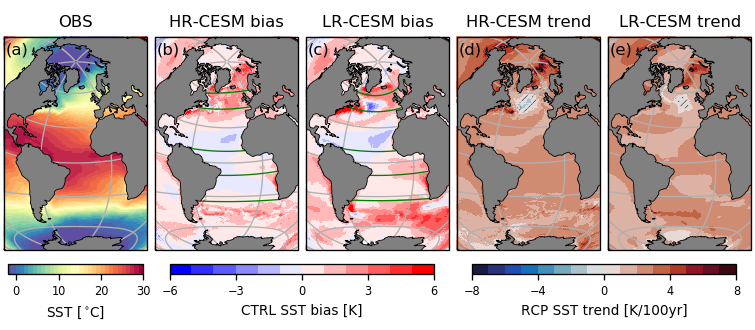

In [11]:
f = plt.figure(figsize=(6.4,2.8))
y, dy = 0.2, 0.73
for i in range(5):
#     if i<4:  continue
    axt = f.add_axes([i*.2+0.005,y,.19,dy], projection=ccrs.LambertAzimuthalEqualArea(central_longitude=-30, central_latitude=20))
    axt.set_extent((-6e6, 3.5e6, -8.5e6, 1e7), crs=ccrs.LambertAzimuthalEqualArea())
    axt.set_title(['OBS', 'HR-CESM bias', 'LR-CESM bias', 'HR-CESM trend', 'LR-CESM trend'][i])
    if i==0:  # observed mean state
        xa = SST_had
        latname, lonname = 'latitude', 'longitude'
        cax = f.add_axes([0.01,.17,.18,.03])
        label = r'SST [$^\circ\!$C]'
        ticks = np.arange(0,31,10)
        minv, maxv = -2, 30
        cmap = plt.get_cmap('Spectral_r',32)
    elif i==1 or i==2:  # biases
        if i==1:
            xa = (regridder_ocn(SST_ocn)-SST_had_).squeeze()
            cax = f.add_axes([0.225,.17,.35,.03])
            label = 'CTRL SST bias [K]'
            ticks = np.arange(-6,7,3)
            MASK = Atl_MASK_ocn 
        if i==2:
            xa = add_cyclic_rectangular((regridder_low(SST_low)-SST_had_).squeeze())
            MASK = Atl_MASK_low
        latname, lonname  = 'lat', 'lon'
        minv, maxv = -6, 6
        cmap=plt.get_cmap('bwr', 12)
        
        # boundaries
        sd = load_obj(f'{path_results}/sections/section_dict_{["","high","low"][i]}')
        for section in lat_bounds[1:]:
            (lons_, lats_) = lons_lats_from_sdict(s=sd[section], lat=section, MASK=MASK)
            axt.plot(lons_, lats_, transform=ccrs.PlateCarree(), color='g', lw=.8)
        
    elif i==3 or i==4:  # trends
        if i==3:
            xa = SST_rcp
            pv = stats_rcp.p_value
            mask = RMASK_ocn
            cax = f.add_axes([0.625,.17,.35,.03])
            label = 'RCP SST trend [K/100yr]'
            ticks = np.arange(-8,9,4)
        if i==4:
            xa = add_cyclic_POP(SST_lr1)
            pv = add_cyclic_POP(stats_lr1.p_value)
            mask = add_cyclic_POP(RMASK_low)
        
        xa = xa.where(mask>0)
        pv = pv.where(mask>0)
        latname, lonname = 'TLAT', 'TLONG'
        minv, maxv = -8, 8
        cmap = plt.get_cmap('cmo.balance',16)
        if i==3:
            xa = xa.assign_coords({'TLAT':SST_ctrl.TLAT,'TLONG':SST_ctrl.TLONG})
    
    im = axt.pcolormesh(xa[lonname], xa[latname], xa.values, transform=ccrs.PlateCarree(),
                        cmap=cmap, vmin=minv, vmax=maxv)
    if i>2:  # hatches 
        axt.contourf(xa[lonname], xa[latname], pv, [0,0.05,1], colors='none', hatches=[None,'//////'], transform=ccrs.PlateCarree())
        
    if i in [0,1,3]:    
        plt.colorbar(im, cax=cax, orientation='horizontal', label=label, ticks=ticks)
    
    axt.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black', facecolor='grey', linewidth=.5)
    gl = axt.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
    gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    axt.text(0.01, .92, '('+['a', 'b', 'c', 'd', 'e'][i]+')', transform=axt.transAxes)
# plt.savefig(f'{path_results}/SST/SST_HIGH_LOW_bias_trend', dpi=300)
# plt.savefig(f'{path_results}/FW-paper/SST_HIGH_LOW_bias_trend', dpi=300)
# plt.savefig(f'{path_results}/FW-paper/Fig1', dpi=600)


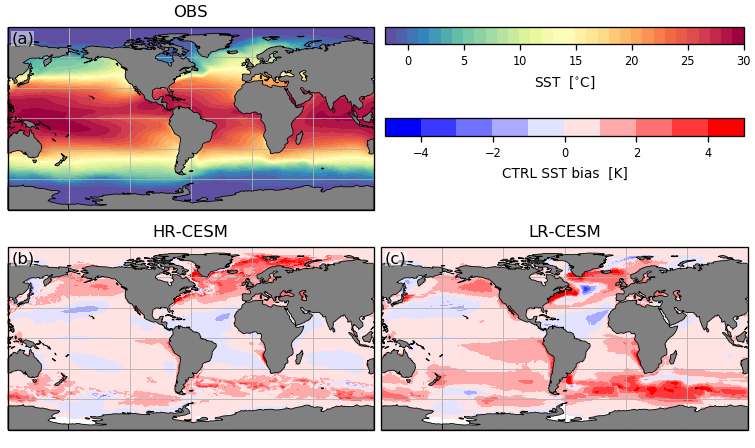

In [12]:
kw1 = dict(lat='lat', lon='lon', label='SST  [$\!^\circ\!$C]', cmap=plt.get_cmap('Spectral_r', 32), vmin=-2, vmax=30)
kw2 = dict(label='CTRL SST bias  [K]', lat='lat',lon='lon', cmap=plt.get_cmap('bwr', 10), vmin=-5, vmax=5)
dh = (regridder_ocn(SST_ocn)-SST_had_).squeeze()
dl = (regridder_low(SST_low)-SST_had_).squeeze()
fn = f'{path_results}/FW-paper/SupplFig1'
bias_maps(do=SST_had_.squeeze(), dh=dh, dl=dl, kw1=kw1, kw2=kw2, fn=fn)